In [1]:
import polars as pl
import os

# Define the path to your data file relative to the project root
# Go up one directory from 'peter-capstone-analysis' to the project root, then into 'data'
data_file_path = os.path.join('..', 'data', 'sampledata_truthsocial.csv') # <-- IMPORTANT: Replace 'your_truth_social_data.csv' with the actual filename

try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # Display the first few rows to verify loading
    print("Data loaded successfully. First 5 rows:")
    print(df.head())

    # Display the data types of the columns
    print("\nData Types:")
    print(df.dtypes)

except FileNotFoundError:
    print(f"Error: Data file not found at {data_file_path}")
    print("Please ensure the filename is correct and the file exists in the 'data/' directory.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Data loaded successfully. First 5 rows:
shape: (5, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ account.d ┆ account.u ┆ account.i ┆ content_c ┆ … ┆ in_reply_ ┆ reblog.id ┆ replies_c ┆ reblogs_ │
│ isplay_na ┆ sername   ┆ d         ┆ leaned    ┆   ┆ to_id     ┆ ---       ┆ ount      ┆ count    │
│ me        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ ---       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ i64       ┆ i64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ suzyQpatr ┆ suzyQpatr ┆ 107842819 ┆ RT @corte ┆ … ┆ null      ┆ 1.1390e17 ┆ 0         ┆ 0        │
│ iot       ┆ iot       ┆ 492508562 ┆ ssteveIt’ ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           

## Step: Isolate and Prepare Post Timestamp (created_at) Column
**Why are we doing this?**

Focus: Our goal is time series analysis, specifically looking for patterns in when posts occur. The created_at column contains this crucial time information. Isolating it removes irrelevant data (like post content, usernames, etc.) for this specific analysis, making the process cleaner and more efficient. We rename it to post_timestamp simply for clarity and consistency with your proposal.




Correct Data Type: Computers need to understand that the values in this column represent points in time, not just sequences of characters (strings) or numbers. Time series analysis functions (like plotting over time, calculating autocorrelations, or aggregating by hour/day) require the data to be in a specific datetime format. If the data is currently a string (e.g., "2023-10-27 10:30:00") or a number (e.g., a Unix timestamp like 1698399000), we must convert it so the software can perform time-based calculations correctly.

**How does this affect the next step?**

Enables Time-Based Operations: Once the post_timestamp column is in the correct datetime format, we can perform essential time series operations. The very next step in your Week 1 plan is Initial Time-Series Diagnostics. This involves:


Visualization: Plotting the number of posts over time (e.g., posts per hour or day). This requires the datetime type to correctly order and space the data points on the time axis.


Aggregation: To perform burst detection or plot posts-per-hour, we need to group the data by time intervals (hour, minute, day). This aggregation relies heavily on the datetime data type.


ACF Calculation: Calculating the Autocorrelation Function (ACF) involves comparing the time series with lagged versions of itself. This inherently requires the data to be ordered correctly by time, which the datetime format ensures.




Foundation for Modeling: All subsequent analysis, including Burst Detection and Temporal Clustering (which involves extracting features like hour-of-day ), fundamentally depends on having accurate and usable timestamp data. Getting this step right is crucial for the validity of all future results.

In [2]:
try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # --- Select and Prepare Timestamp ---
    ts_df = df.select(
        pl.col('created_at').alias('post_timestamp')
    )
    print("Original data type of post_timestamp:")
    print(ts_df.dtypes)

    if ts_df['post_timestamp'].dtype == pl.String:
        print("\nConverting string (ISO 8601 format) to datetime...")
        try:
            # Polars' str.to_datetime should handle ISO 8601 including timezone automatically
            # Let's try without specifying a format first.
            ts_df = ts_df.with_columns(
                pl.col('post_timestamp').str.to_datetime().alias('post_timestamp')
            )
            print("Automatic conversion successful!")

        except Exception as e:
            # If automatic fails again, try a specific format string for ISO 8601
            # %Y-%m-%dT%H:%M:%S%.f%:z handles microseconds and timezone like +00:00
            print(f"Automatic conversion failed again ({e}). Trying specific ISO 8601 format...")
            iso_format = "%Y-%m-%dT%H:%M:%S%.f%:z"
            ts_df = ts_df.with_columns(
                pl.col('post_timestamp').str.to_datetime(format=iso_format).alias('post_timestamp')
            )
            print("Specific format conversion successful!")

        print("\nConverted data type:")
        print(ts_df.dtypes)
        print("\nNote: Timestamps might now be timezone-aware (e.g., datetime[μs, UTC])")


    # Display the first few rows with the prepared timestamp
    print("\nPrepared Timestamp Data:")
    print(ts_df.head())

except pl.ColumnNotFoundError:
    print("Error: Column 'created_at' not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")

Original data type of post_timestamp:
[String]

Converting string (ISO 8601 format) to datetime...
Automatic conversion failed again (`strptime` / `to_datetime` was called with no format and no time zone, but a time zone is part of the data.

This was previously allowed but led to unpredictable and erroneous results. Give a format string, set a time zone or perform the operation eagerly on a Series instead of on an Expr.). Trying specific ISO 8601 format...
Specific format conversion successful!

Converted data type:
[Datetime(time_unit='us', time_zone='UTC')]

Note: Timestamps might now be timezone-aware (e.g., datetime[μs, UTC])

Prepared Timestamp Data:
shape: (5, 1)
┌─────────────────────────────┐
│ post_timestamp              │
│ ---                         │
│ datetime[μs, UTC]           │
╞═════════════════════════════╡
│ 2025-01-27 05:04:04.797 UTC │
│ 2025-01-27 05:07:12.056 UTC │
│ 2025-01-27 05:07:16.126 UTC │
│ 2025-01-27 05:07:45.702 UTC │
│ 2025-01-27 05:12:06.137 UTC │
└

**1. Visualization**

**Why do this?** Plotting the data over time is the first step in understanding its behavior. We visually check for:

- Trends: Is the posting activity generally increasing or decreasing over time ?
- Seasonality: Are there repeating patterns within fixed time intervals (e.g., daily, weekly) ?
- Anomalies/Bursts: Are there obvious spikes or unusual periods of activity?
- Variance Stability: Does the amount of fluctuation change depending on the level of activity? (Needed for step 3)

**How does this affect the next step?** Visual inspection gives us initial clues about the data's structure. If we see strong seasonality or trends, it guides how we might approach modeling or transformation later. Obvious bursts might corroborate the findings of our burst detection algorithm.

In [3]:
import plotly.express as px
import polars as pl # Make sure polars is imported

try:
    # --- Ensure data is sorted by timestamp ---
    print("Sorting data by post_timestamp...")
    ts_df_sorted = ts_df.sort("post_timestamp")
    print("Sorting complete.")

    # --- Aggregate Data by Hour ---
    # Use the sorted DataFrame (ts_df_sorted) here
    print("Aggregating posts per hour...")
    posts_per_hour = ts_df_sorted.group_by_dynamic(
        index_column="post_timestamp",
        every="1h", # Aggregate into 1-hour bins
        # Optional: include_boundaries=True can sometimes help with edge cases
    ).agg(
        # Use pl.len() instead of pl.count() as recommended by the warning
        pl.len().alias('post_count') # Count posts in each bin
    ).sort("post_timestamp") # Sorting again after aggregation is good practice
    print("Aggregation complete.")

    print("\nAggregated posts per hour (first 5 rows):")
    print(posts_per_hour.head())

    # --- Create Interactive Plot ---
    print("Creating plot...")
    fig = px.line(posts_per_hour.to_pandas(), # Plotly often works well with Pandas DataFrames
                  x='post_timestamp',
                  y='post_count',
                  title='Posts Per Hour on Truth Social Sample',
                  labels={'post_timestamp': 'Time', 'post_count': 'Number of Posts'})

    fig.show() # Display the plot in the notebook
    print("Plot displayed.")

    # Optional: Save the plot as an HTML file
    # fig.write_html("posts_per_hour_plot.html")
    # print("\nPlot saved as posts_per_hour_plot.html")

except Exception as e:
    print(f"An error occurred: {e}")

Sorting data by post_timestamp...
Sorting complete.
Aggregating posts per hour...
Aggregation complete.

Aggregated posts per hour (first 5 rows):
shape: (5, 2)
┌─────────────────────────┬────────────┐
│ post_timestamp          ┆ post_count │
│ ---                     ┆ ---        │
│ datetime[μs, UTC]       ┆ u32        │
╞═════════════════════════╪════════════╡
│ 2025-01-27 05:00:00 UTC ┆ 64         │
│ 2025-01-27 06:00:00 UTC ┆ 35         │
│ 2025-01-27 07:00:00 UTC ┆ 13         │
│ 2025-01-27 08:00:00 UTC ┆ 20         │
│ 2025-01-27 09:00:00 UTC ┆ 29         │
└─────────────────────────┴────────────┘
Creating plot...


Plot displayed.


Based on the plot ("Posts Per Hour on Truth Social Sample"):


- Trend: In this timeframe (approx. Jan 28 - Feb 15, 2025), there isn't a clear long-term increasing or decreasing trend . The overall level seems relatively stable, aside from fluctuations.

- Seasonality: There's a very strong, repeating pattern within each day (or possibly every 24 hours). Activity peaks and then drops significantly, suggesting daily seasonality . People likely post more during certain hours and less during others (e.g., overnight). There might be a weaker weekly pattern too, but the daily one dominates.

- Anomalies/Bursts: There is a particularly large spike in activity around February 13th. This peak is noticeably higher than the typical daily peaks, making it a candidate for a "burst"  that our burst detection algorithm might identify later. Other peaks around Jan 29/30 and Feb 4 also stand out, though less dramatically.


- Variance: The size of the fluctuations (variance) might be slightly larger during the periods of highest activity (like Feb 13th), which could suggest the variance isn't perfectly constant. We'll keep this in mind.

**2. Autocorrelation Function (ACF)**

**Why do this?** While our eyes see patterns, the Autocorrelation Function (ACF) provides a statistical measure of how correlated the time series is with lagged versions of itself . It helps us objectively confirm if the patterns we see are statistically significant or just random noise.


- onfirming Patterns: Significant correlations at specific lags confirm the presence of non-random patterns like seasonality or cycles. For example, strong daily seasonality should show high correlation at lags 24, 48, 72, etc. (hours).


- Checking for White Noise: If no lags (except lag 0) show significant correlation, the series might be "white noise" – purely random and unpredictable . Our plot clearly isn't white noise, but ACF confirms this statistically.


**How does this affect the next step?**


- Validation for Modeling: Confirming significant autocorrelation validates that the time series contains predictable patterns, making it suitable for modeling (like burst detection).

- Identifying Seasonality: The lags with significant spikes in the ACF plot pinpoint the period of seasonality (e.g., a spike at lag 24 confirms the 24-hour pattern). This is crucial information for later modeling steps, especially if we were to use seasonal models like SARIMA.


- Input for Order Selection: In later stages (beyond Week 1), the pattern of decay in the ACF helps in selecting appropriate orders for models like ARMA .

Calculating and plotting ACF...


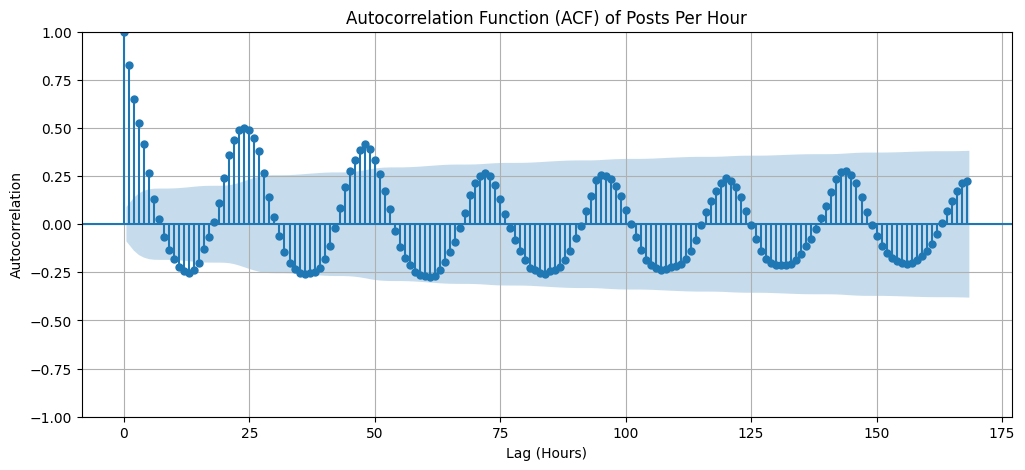

ACF plot displayed.


In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

try:
    # --- Calculate and Plot ACF ---
    print("Calculating and plotting ACF...")

    # Determine a reasonable number of lags to check (e.g., a few days worth of hours)
    n_lags = 7 * 24 # Check correlations up to 7 days back

    fig, ax = plt.subplots(figsize=(12, 5)) # Create a plot figure

    # plot_acf calculates and plots the ACF
    # posts_per_hour['post_count'] is the series we want to analyze
    plot_acf(posts_per_hour['post_count'], lags=n_lags, ax=ax)

    ax.set_title('Autocorrelation Function (ACF) of Posts Per Hour')
    ax.set_xlabel('Lag (Hours)')
    ax.set_ylabel('Autocorrelation')
    plt.grid(True)
    plt.show() # Display the plot
    print("ACF plot displayed.")

except Exception as e:
    print(f"An error occurred during ACF calculation/plotting: {e}")

The ACF plot provides strong statistical confirmation of the patterns we saw in the previous visualization:

- Not White Noise: The plot shows many lags with correlation spikes far outside the blue confidence interval. This confirms the time series is not random noise and contains significant, predictable patterns.

- Strong Daily Seasonality: There are very prominent, significant positive spikes at lags 24, 48, 72, 96, 120, 144, and 168. This is a classic signature of a strong 24-hour (daily) seasonal pattern. It means the number of posts at any given hour is highly correlated with the number of posts 24 hours prior (and 48 hours prior, etc.).

- Within-Day Correlation: The lags between the daily spikes (e.g., lags 1-23) also show a pattern. The correlation starts high and positive (lag 1) and then dips, indicating that posting activity in one hour is also related to the activity in the immediately preceding and following hours.

In summary, the ACF plot confirms that the data has a strong, modelable 24-hour seasonal pattern, validating its suitability for time-series modeling.

**3. Transformation (Checking Variance)**
**Why do this?** This is the final diagnostic step for Week 1, as mentioned in your proposal. Many time-series models (and statistical tests) perform best when the variance of the data (the "spread" or "volatility") is constant over time (a property called homoscedasticity).

Our visual plot suggested that the variance might increase when the posting level increases (this is heteroscedasticity ). If this is the case, applying a mathematical transformation, such as a logarithm (log(y_t)), can help stabilize the variance, making the patterns cleaner and the model more reliable.



**How does this affect the next step?** If we find the variance is unstable, we should apply a log transformation to our post_count data. All subsequent analysis (like Burst Detection in Week 2) would then be performed on this transformed data (log(post_count)) rather than the raw counts. If the variance looks stable, we can proceed with the raw post_count data.

In [6]:
import numpy as np # Import numpy for log function

try:
    # --- Apply Log Transformation ---
    # We use log1p, which calculates log(1 + x), to avoid errors if post_count is 0
    posts_per_hour_transformed = posts_per_hour.with_columns(
        pl.col('post_count').log1p().alias('log_post_count')
    )

    print("Aggregated data with log transformation (first 5 rows):")
    print(posts_per_hour_transformed.head())

    # --- Create Comparison Plots ---

    # Plot 1: Original Data
    fig_original = px.line(posts_per_hour.to_pandas(),
                           x='post_timestamp',
                           y='post_count',
                           title='Original Posts Per Hour (Raw Count)')

    # Plot 2: Log-Transformed Data
    fig_log = px.line(posts_per_hour_transformed.to_pandas(),
                      x='post_timestamp',
                      y='log_post_count',
                      title='Log-Transformed Posts Per Hour (log(1 + Count))')

    print("Displaying plots for variance comparison...")
    fig_original.show()
    fig_log.show()
    print("Plots displayed.")

except Exception as e:
    print(f"An error occurred during transformation or plotting: {e}")

Aggregated data with log transformation (first 5 rows):
shape: (5, 3)
┌─────────────────────────┬────────────┬────────────────┐
│ post_timestamp          ┆ post_count ┆ log_post_count │
│ ---                     ┆ ---        ┆ ---            │
│ datetime[μs, UTC]       ┆ u32        ┆ f64            │
╞═════════════════════════╪════════════╪════════════════╡
│ 2025-01-27 05:00:00 UTC ┆ 64         ┆ 4.174387       │
│ 2025-01-27 06:00:00 UTC ┆ 35         ┆ 3.583519       │
│ 2025-01-27 07:00:00 UTC ┆ 13         ┆ 2.639057       │
│ 2025-01-27 08:00:00 UTC ┆ 20         ┆ 3.044522       │
│ 2025-01-27 09:00:00 UTC ┆ 29         ┆ 3.401197       │
└─────────────────────────┴────────────┴────────────────┘
Displaying plots for variance comparison...


Plots displayed.


**Analysis of Transformation**
- **Original Plot:** In the raw count data, the variance is unstable (heteroscedastic). The fluctuations during normal periods (e.g., Feb 5-10) are small (maybe 0-150), while the fluctuations during the major spike on Feb 13 are massive (from a low base to over 600). This difference in scale can skew the results of statistical models.


- **Log-Transformed Plot:** The log transformation has successfully stabilized the variance. The peaks and valleys now oscillate within a much more consistent range (roughly 2.5 to 6.0). The massive spike on Feb 13 is compressed and now looks proportional to the other large daily spikes (like the one on Jan 30), rather than exponentially larger.

**Decision and Next Steps**
This log-transformed data is much more suitable for the time-series modeling and statistical tests we plan to do, as it better meets the assumption of constant variance.

Therefore, for our Week 2 analysis (Burst Detection and Clustering), we will use the log_post_count column from the posts_per_hour_transformed DataFrame.

This completes all the tasks outlined for Week 1 of your proposal:

1. Setup & Data Exploration: Done.

2. Load Data: Done.

3. Perform Initial Time-Series Diagnostics:

    - Visualization: Done.

    - Autocorrelation (ACF): Done.

    - Transformation: Done.